In [9]:
import os
import yaml
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_openai import OpenAIEmbeddings
from numpy import array, dot
from numpy.linalg import norm
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt


In [10]:
with open("config.yaml", "r") as config_file:
    config = yaml.safe_load(config_file)
    os.environ["OPENAI_API_KEY"] = config["OPENAI_API_KEY"]

In [11]:
documents = [
    "This is the first document. It contains important information about the project.",
    "This is the second document. It also has some relevant details.",
    "Here is the third document. It provides additional context and data.",
]

In [12]:
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=1000,
    chunk_overlap=100,
    length_function=len,
)

chunks = text_splitter.create_documents(documents)

print("Chunks created:")
for i, chunk in enumerate(chunks):
    print(f"Chunk {i+1}: {chunk.page_content}\n")

Chunks created:
Chunk 1: This is the first document. It contains important information about the project.

Chunk 2: This is the second document. It also has some relevant details.

Chunk 3: Here is the third document. It provides additional context and data.



In [13]:
print(f"Total chunks created: {len(chunks)}")

Total chunks created: 3


In [14]:
embeddings = OpenAIEmbeddings(model="text-embedding-ada-002")
print(embeddings)

client=<openai.resources.embeddings.Embeddings object at 0x7ab49bc52a20> async_client=<openai.resources.embeddings.AsyncEmbeddings object at 0x7ab49b996630> model='text-embedding-ada-002' dimensions=None deployment='text-embedding-ada-002' openai_api_version=None openai_api_base=None openai_api_type=None openai_proxy=None embedding_ctx_length=8191 openai_api_key=SecretStr('**********') openai_organization=None allowed_special=None disallowed_special=None chunk_size=1000 max_retries=2 request_timeout=None headers=None tiktoken_enabled=True tiktoken_model_name=None show_progress_bar=False model_kwargs={} skip_empty=False default_headers=None default_query=None retry_min_seconds=4 retry_max_seconds=20 http_client=None http_async_client=None check_embedding_ctx_length=True


In [15]:
embedded_chunks = embeddings.embed_documents([chunk.page_content for chunk in chunks])

In [16]:
print("Embeddings generated: (showing only the first 5 elements of each embedding):")
for i, embedding in enumerate(embedded_chunks):
    print(f"Embedding {i+1}: {embedding[:5]}")

Embeddings generated: (showing only the first 5 elements of each embedding):
Embedding 1: [0.0032089948654174805, 0.0022730380296707153, -0.03662950173020363, -0.04163866490125656, 0.0017382055521011353]
Embedding 2: [-0.0012058042921125889, 0.00944546703249216, 0.004042793996632099, -0.02976996824145317, -0.0005618713330477476]
Embedding 3: [-0.015314199961721897, 0.00760264927521348, 0.0006695708143524826, -0.03580119460821152, 0.011448214761912823]


In [17]:
def coisinea_similarity(vec1, vec2):
    return dot(vec1, vec2) / (norm(vec1) * norm(vec2))

In [18]:
print("Similarity between all chunks:")
similarities = []  
for i in range(len(embedded_chunks)):
    for j in range(i + 1, len(embedded_chunks)):
        sim = coisinea_similarity(array(embedded_chunks[i]), array(embedded_chunks[j]))
        similarities.append((i, j, sim))
        print(f"Similarity between Chunk {i+1} and Chunk {j+1}: {sim:.4f}")

Similarity between all chunks:
Similarity between Chunk 1 and Chunk 2: 0.8838
Similarity between Chunk 1 and Chunk 3: 0.8475
Similarity between Chunk 2 and Chunk 3: 0.9111


Visualization 

In [19]:
embedded_chunks_array = array(embedded_chunks)

In [20]:
pca = PCA(n_components=2)
pca_result = pca.fit_transform(embedded_chunks_array)

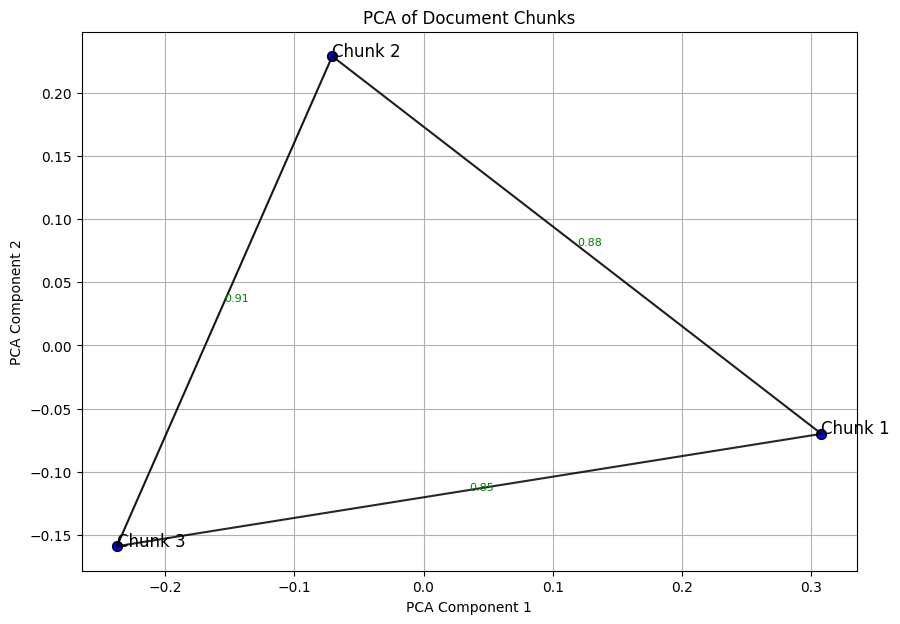

In [21]:
plt.figure(figsize=(10, 7))
plt.scatter(pca_result[:, 0], pca_result[:, 1], c='blue', edgecolors='k', s=50)
for i, chunk in enumerate(chunks):
    plt.text(pca_result[i, 0], pca_result[i, 1], f'Chunk {i+1}', fontsize=12)
for (i, j, sim) in similarities:
    plt.plot([pca_result[i, 0], pca_result[j, 0]], [pca_result[i, 1], pca_result[j, 1]], 'k-', alpha=sim)
    mid_x = (pca_result[i, 0] + pca_result[j, 0]) / 2
    mid_y = (pca_result[i, 1] + pca_result[j, 1]) / 2
    plt.text(mid_x, mid_y, f'{sim:.2f}', color='green', fontsize=8)
plt.title('PCA of Document Chunks')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.grid(True)
plt.show()